In [1]:
import os
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
import mistsim as ms
import scipy as sp

n_cpus = 4
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
NBINS = 1

### Load data

['ant_temp', 'freq', 'lst']


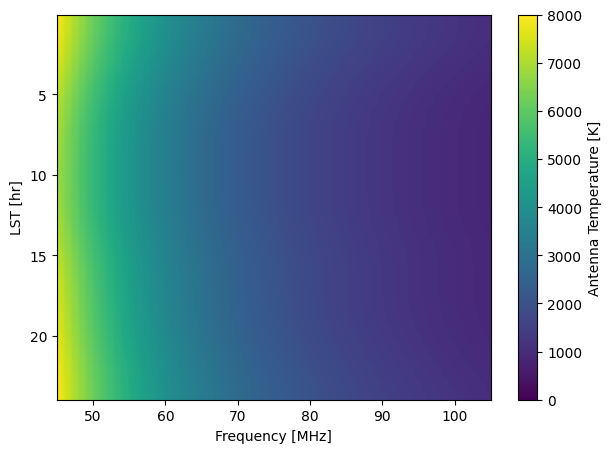

In [3]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
FLOW = 45
FHIGH = 105
indx = (freq >= FLOW) * (freq <= FHIGH)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

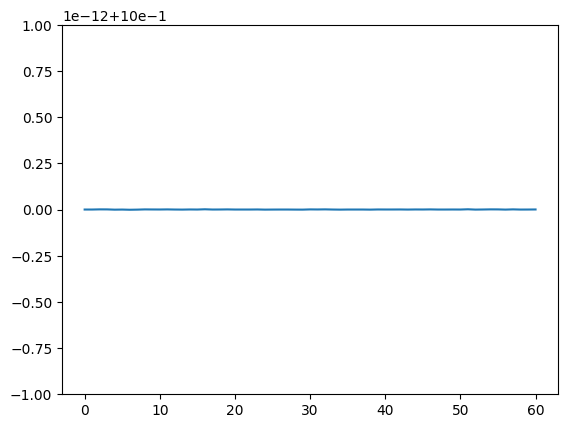

In [4]:
cut = nspec % NBINS
if cut == 0:
    fg_bin = temp.copy()
else:
    fg_bin = temp[:-cut]
fg_bin = fg_bin.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)  # this discards the last 6 min integration

plt.figure()
plt.plot(fg_bin.T/fg_mean[:, None])
plt.show()

### Global signal

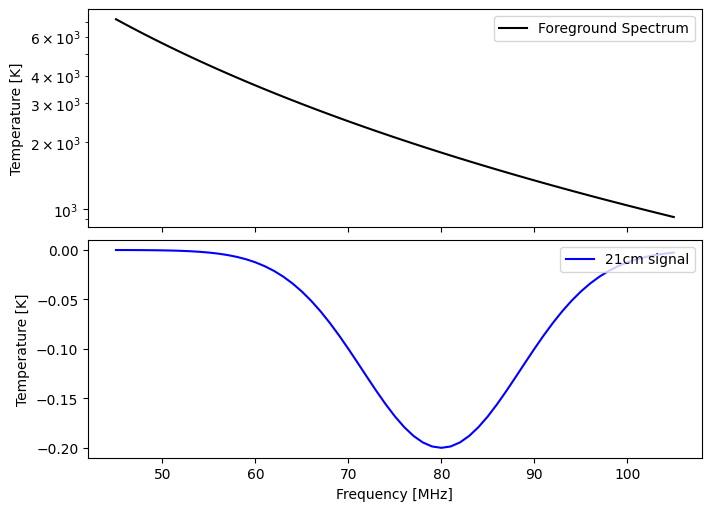

In [5]:
# injected global signal
def gauss(f, a=-0.2, w=20, nu21=80):
    """
    Gaussian in terms of frequency, amplitude, FWHM, and center freq. Default parameters are the ones used in Monsalve et al. 2023b.
    """
    return a * np.exp(-1/2 *((f-nu21) / w)**2 *8*np.log(2))

TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Foreground model

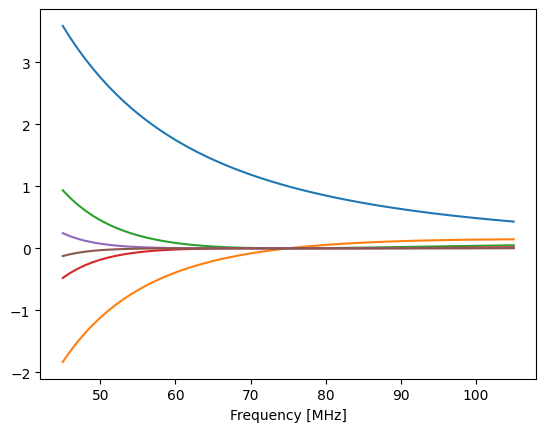

In [6]:
A = ms.utils.design_mat(freq, 6)

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

# Chromaticity correction

['ant_temp', 'freq', 'lst']


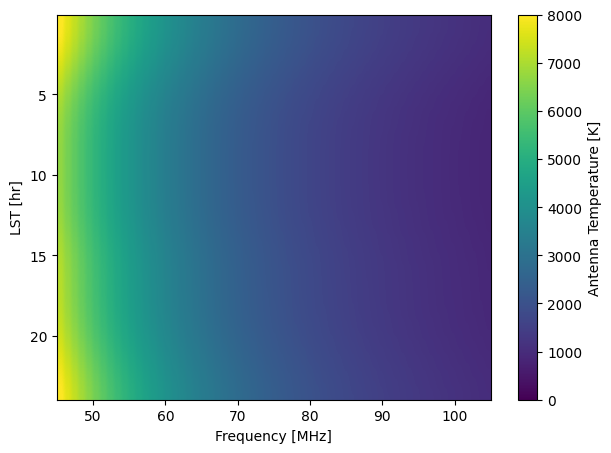

In [7]:
ac_temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains_achromatic_75MHz.hdf5",
    print_key=True,
)[-1]

ac_temp = ac_temp[:, indx]


plt.figure(figsize=(7,5))
im = plt.imshow(
    ac_temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

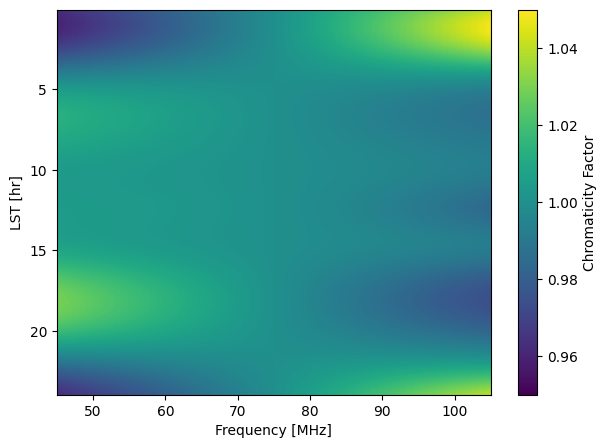

In [8]:
chrom = temp / ac_temp  # chromaticity factor (BF)

plt.figure(figsize=(7,5))
im = plt.imshow(
    chrom, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0.95, 1.05)
plt.colorbar(label="Chromaticity Factor")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

In [9]:
ctemp = (temp+TRUE_T21) / chrom  # = ac temp, the waterfall due to achromatic beam

print(np.allclose(ctemp, ac_temp))
if cut == 0:
    binned = ctemp.copy()
else:
    binned = ctemp[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
chrom_mean = chrom.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
print(chrom_mean.shape)

tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = ctemp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

False
(1, 61)


In [10]:
s_christian = np.sqrt(1/sigma_inv[0])
s_raul = (binned[0] / binned[0][freq == 75]) * 3e-3
print(np.max(np.abs(s_christian-s_raul)))
print(np.allclose(s_raul, s_christian))

1.734723475976807e-18
True


In [11]:
noise_raul = np.random.normal(scale=s_raul)

In [12]:
NFG = [5]
#lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise_raul, np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]

In [13]:
nparticles = 64
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus) 
results = sampler.run_sampler(lst_bins, add_samples=10000)

Iter: 45it [01:25,  1.89s/it, beta=1, calls=10624, ESS=0.97, logZ=-47.6, accept=0.194, N=2, scale=1.14, corr=0.746]        
Iter: 157it [00:13, 11.62it/s, beta=1, calls=35776, ESS=0.95, logZ=-47.6, accept=0.189, N=3, scale=1.28, corr=0.706]


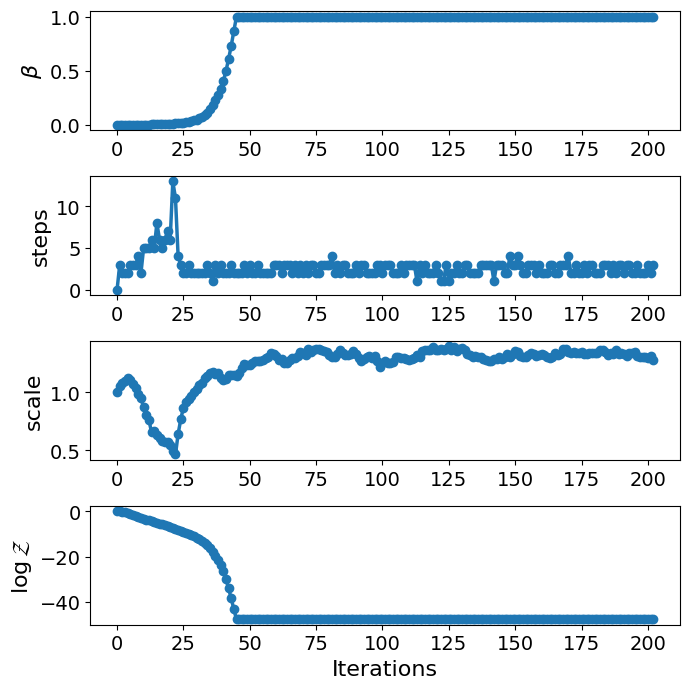

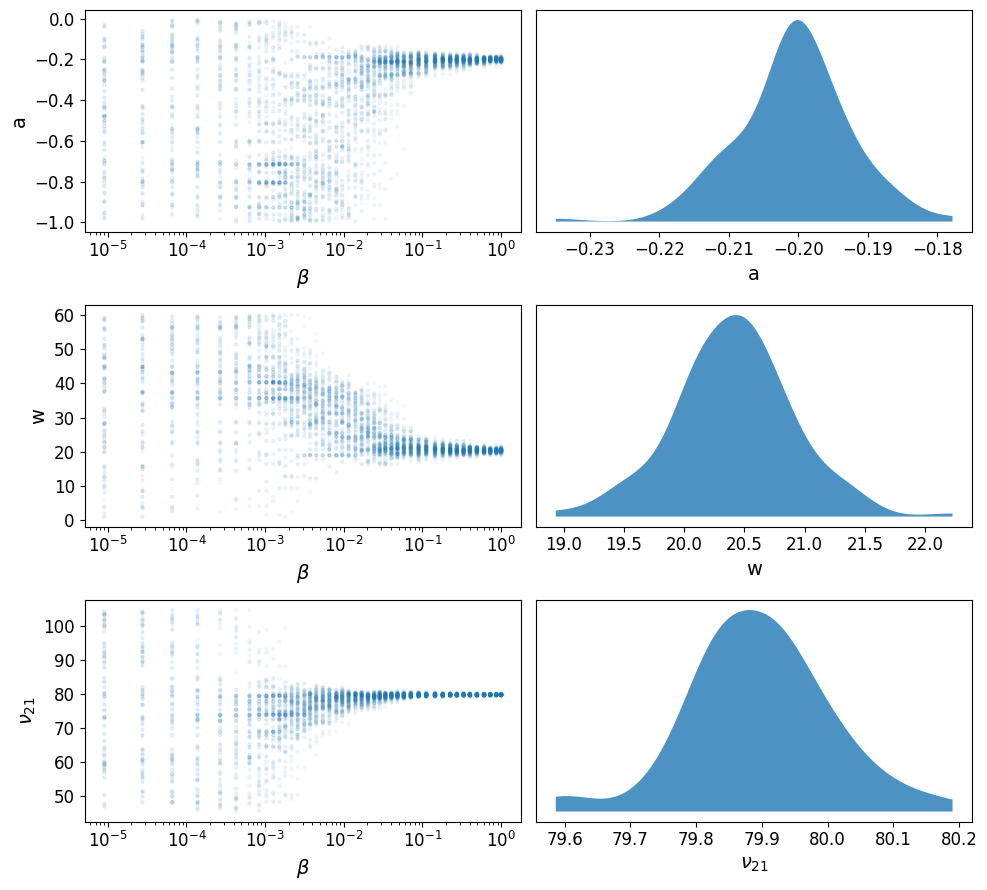

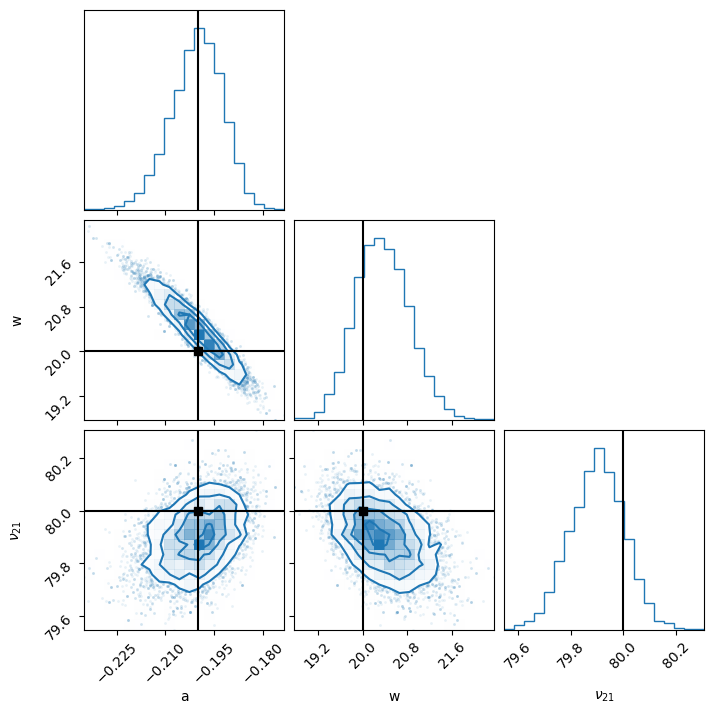

In [14]:
_ = pc.plotting.run(results, width=7, height=7)
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [15]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.20020336 20.36795    79.90197   ]
Standard deviation values =  [0.00796358 0.47456986 0.10294475]

[0.10157628 1.80651677 0.12268795]
[0.02553615 0.77533462 0.95225928]


## With my noise

In [16]:
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]

In [17]:
nparticles = 64
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus) 
results = sampler.run_sampler(lst_bins, add_samples=10000)

Iter: 45it [01:38,  2.19s/it, beta=1, calls=9024, ESS=0.975, logZ=-43.7, accept=0.34, N=2, scale=1.14, corr=0.684]        
Iter: 157it [00:13, 11.62it/s, beta=1, calls=30080, ESS=0.95, logZ=-43.7, accept=0.252, N=2, scale=1.18, corr=0.707]


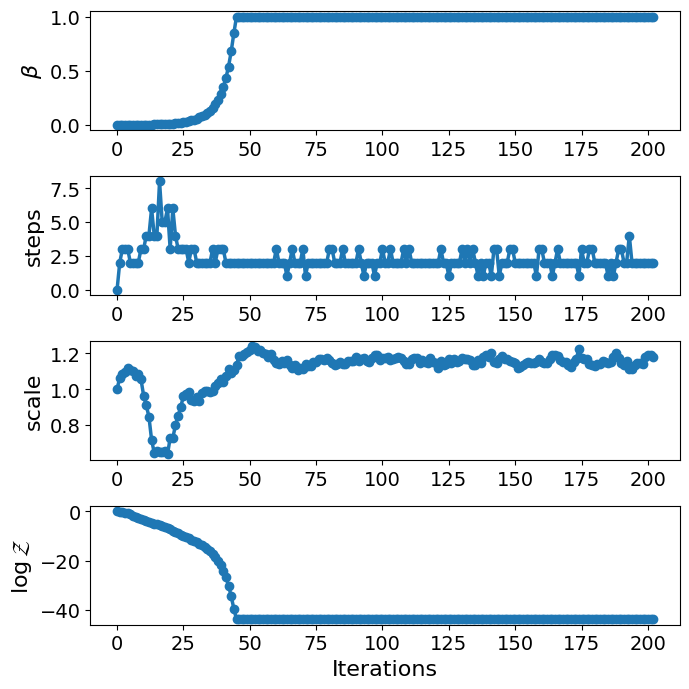

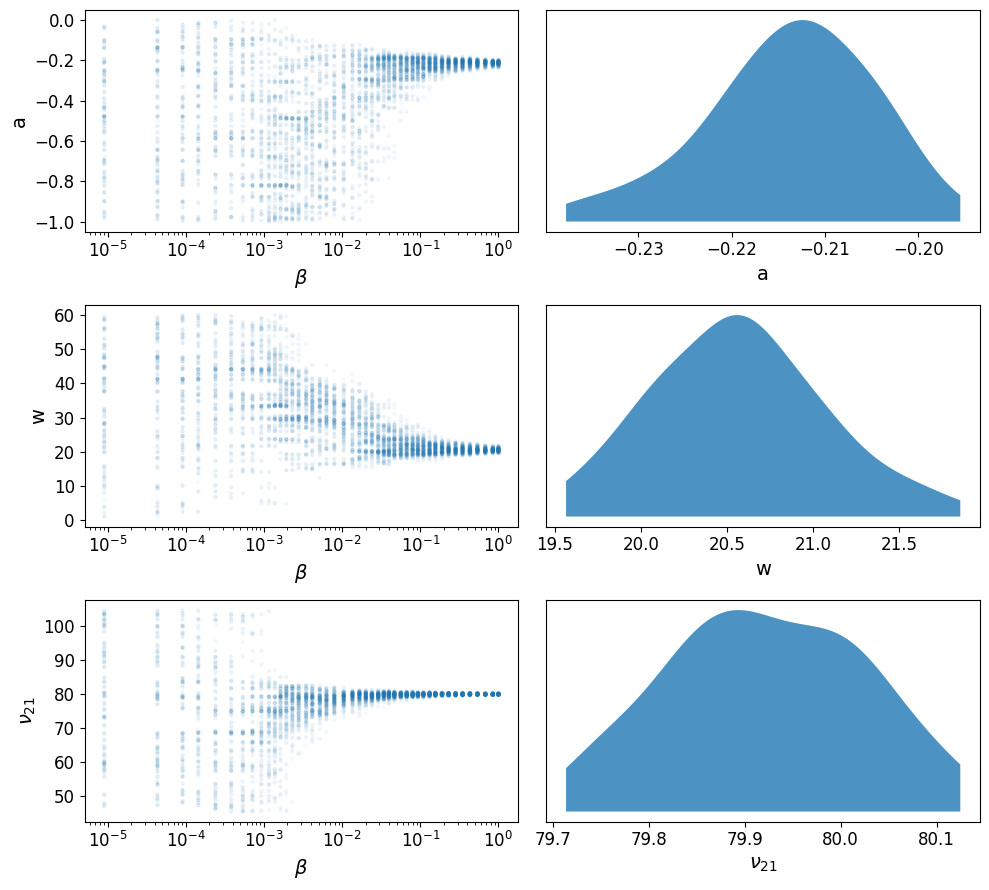

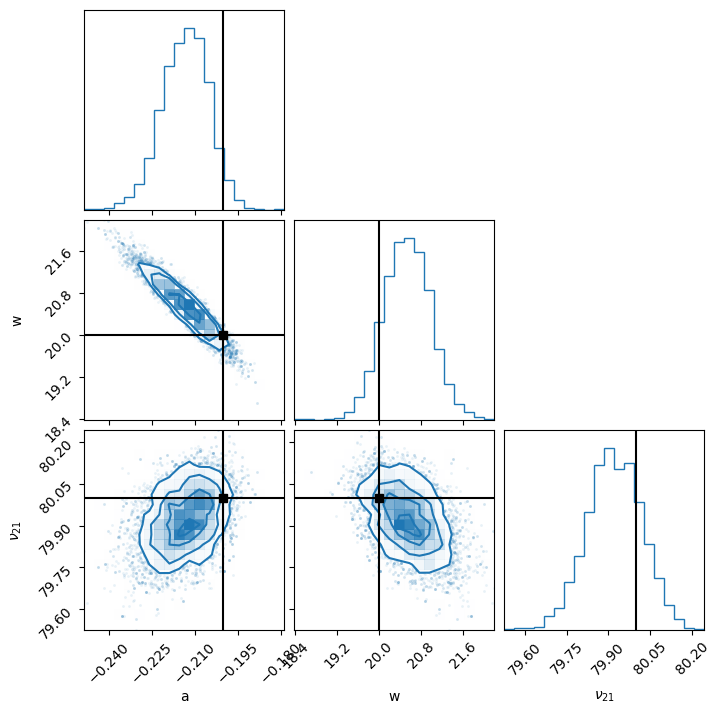

In [18]:
_ = pc.plotting.run(results, width=7, height=7)
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [19]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.21327661 20.53713    79.92329   ]
Standard deviation values =  [0.00809407 0.44470626 0.09707145]

[6.22506603 2.61541095 0.09598399]
[1.64028895 1.20783178 0.79027937]


## Check std of noise

In [20]:
seed = 1913
rng = np.random.default_rng(seed)
noise_std = noise_75 * binned / t75 / np.sqrt(tint_ratio)
noise_std = noise_std * np.ones((1000000, 1))
noise = rng.normal(scale=noise_std)

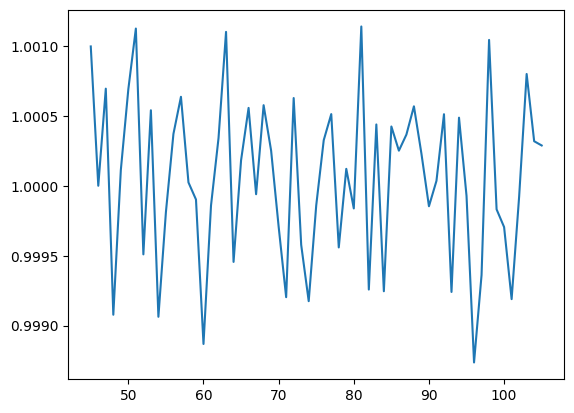

In [21]:
plt.figure()
plt.plot(freq, binned[0]/np.std(noise, axis=0)/t75*noise_75)
plt.show()

## Try different seeds

In [22]:
noise = {}
seeds = [0, 21, 42, 1913, 2024, 16384]
for seed in seeds:
    n, sinv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio, seed=seed)
    assert np.allclose(sinv, sigma_inv)
    noise[seed] = n

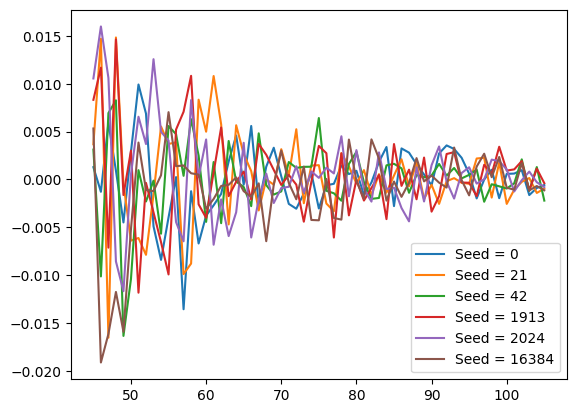

In [23]:
plt.figure()
for k, v in noise.items():
    plt.plot(freq, v[0], label=f"Seed = {k}")
plt.legend()
plt.show()

In [24]:
def print_res(results):
    estimated_params = np.mean(results['samples'], axis=0)
    std_vals = np.std(results['samples'], axis=0)
    print('Mean values = ', estimated_params)
    print('Standard deviation values = ', std_vals)
    print()
    print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
    print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

In [25]:
nparticles = 64
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus)

In [26]:
all_res = {}
for seed in seeds:
    n = noise[seed]
    lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+n[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]
    results = sampler.run_sampler(lst_bins, add_samples=10000)
    all_res[seed] = results
    print(f"SEED: {seed}")
    print_res(results)

Iter: 46it [01:18,  1.70s/it, beta=1, calls=9152, ESS=0.969, logZ=-33.7, accept=0.219, N=2, scale=1.16, corr=0.608]       
Iter: 157it [00:12, 13.04it/s, beta=1, calls=31104, ESS=0.95, logZ=-33.7, accept=0.282, N=2, scale=1.16, corr=0.742]

SEED: 0
Mean values =  [-0.19844176 19.719925   79.940285  ]
Standard deviation values =  [0.00672743 0.41322416 0.09473567]

[0.78523858 1.4202644  0.07469985]
[0.23162507 0.67778    0.63033563]



Iter: 44it [01:19,  1.82s/it, beta=1, calls=8832, ESS=0.974, logZ=-40.3, accept=0.288, N=2, scale=1.25, corr=0.639]       
Iter: 157it [00:15, 10.15it/s, beta=1, calls=34112, ESS=0.95, logZ=-40.3, accept=0.251, N=2, scale=1.36, corr=0.667] 


SEED: 21
Mean values =  [-0.21275339 20.587116   79.89413   ]
Standard deviation values =  [0.00812587 0.45277828 0.10062224]

[5.9944453  2.85186247 0.13251676]
[1.56947891 1.29669701 1.052184  ]


Iter: 45it [01:15,  1.68s/it, beta=1, calls=11520, ESS=0.993, logZ=-32.4, accept=0.309, N=2, scale=1.2, corr=0.68]         
Iter: 157it [00:15, 10.38it/s, beta=1, calls=34304, ESS=0.95, logZ=-32.4, accept=0.294, N=2, scale=1.38, corr=0.74] 


SEED: 42
Mean values =  [-0.20026389 19.944624   79.983315  ]
Standard deviation values =  [0.00721278 0.43083498 0.09603854]

[0.13176996 0.27764902 0.02086121]
[0.03658612 0.12853193 0.17373739]


Iter: 46it [01:15,  1.65s/it, beta=1, calls=8704, ESS=0.998, logZ=-43.2, accept=0.18, N=2, scale=1.21, corr=0.675]         
Iter: 157it [00:13, 12.01it/s, beta=1, calls=30656, ESS=0.95, logZ=-43.2, accept=0.273, N=2, scale=1.2, corr=0.61]  

SEED: 1913
Mean values =  [-0.21372122 20.557129   79.92367   ]
Standard deviation values =  [0.00819073 0.4502625  0.09735613]

[6.42014677 2.7101494  0.09550624]
[1.67521211 1.23734249 0.78405023]



Iter: 45it [01:20,  1.79s/it, beta=1, calls=10368, ESS=0.973, logZ=-37.8, accept=0.254, N=2, scale=1.22, corr=0.719]      
Iter: 157it [00:14, 10.99it/s, beta=1, calls=34752, ESS=0.95, logZ=-37.8, accept=0.251, N=3, scale=1.55, corr=0.717]


SEED: 2024
Mean values =  [-0.20777304 20.368656   80.10783   ]
Standard deviation values =  [0.00815522 0.45553115 0.09670995]

[3.74112278 1.8099189  0.13460137]
[0.95313765 0.80928858 1.11494454]


Iter: 43it [01:17,  1.79s/it, beta=1, calls=8448, ESS=0.982, logZ=-35.6, accept=0.309, N=2, scale=1.27, corr=0.74]        
Iter: 157it [00:13, 11.85it/s, beta=1, calls=30400, ESS=0.95, logZ=-35.6, accept=0.17, N=2, scale=1.38, corr=0.745] 

SEED: 16384
Mean values =  [-0.21365127 20.68857    79.87785   ]
Standard deviation values =  [0.00844698 0.46311328 0.0980022 ]

[6.3895102  3.32826301 0.15291674]
[1.61611295 1.4868285  1.24636602]


In [34]:
for seed in [42, 16384]: 
    results = all_res[seed]
    print(f"SEED: {seed}")
    print_res(results)

SEED: 42
Mean values =  [-0.20026389 19.944624   79.983315  ]
Standard deviation values =  [0.00721278 0.43083498 0.09603854]

[0.13176996 0.27764902 0.02086121]
[0.03658612 0.12853193 0.17373739]
SEED: 16384
Mean values =  [-0.21365127 20.68857    79.87785   ]
Standard deviation values =  [0.00844698 0.46311328 0.0980022 ]

[6.3895102  3.32826301 0.15291674]
[1.61611295 1.4868285  1.24636602]


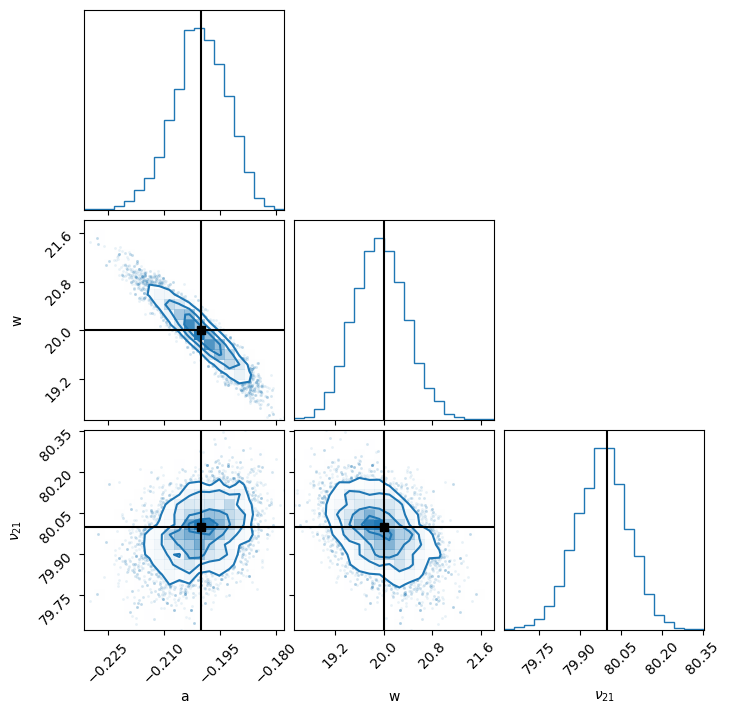

In [27]:
_ = pc.plotting.corner(all_res[42], labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

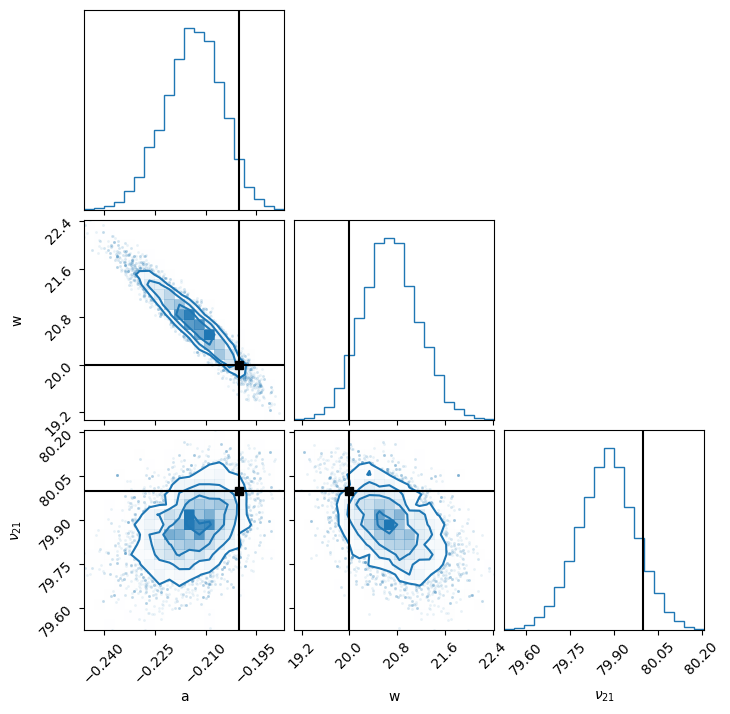

In [28]:
_ = pc.plotting.corner(all_res[16384], labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

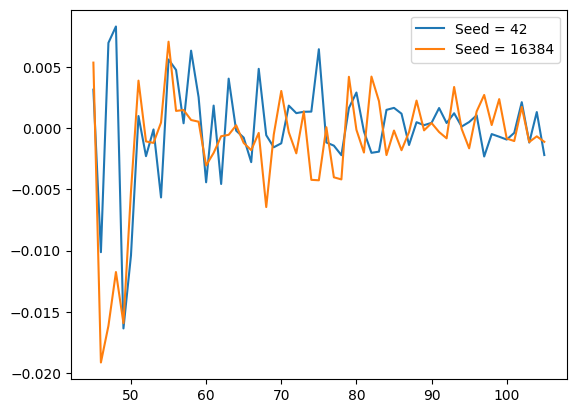

In [29]:
plt.figure()
plt.plot(freq, noise[42][0], label="Seed = 42")
plt.plot(freq, noise[16384][0], label="Seed = 16384")
plt.legend()
plt.show()

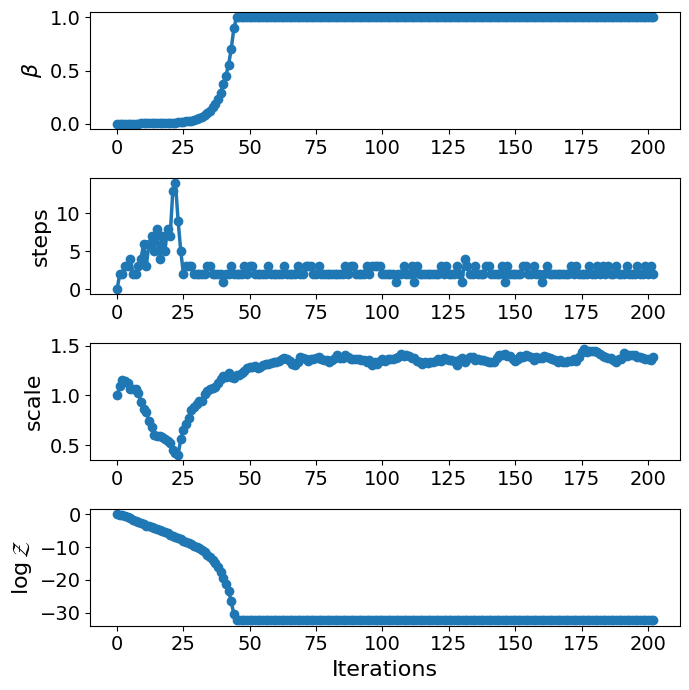

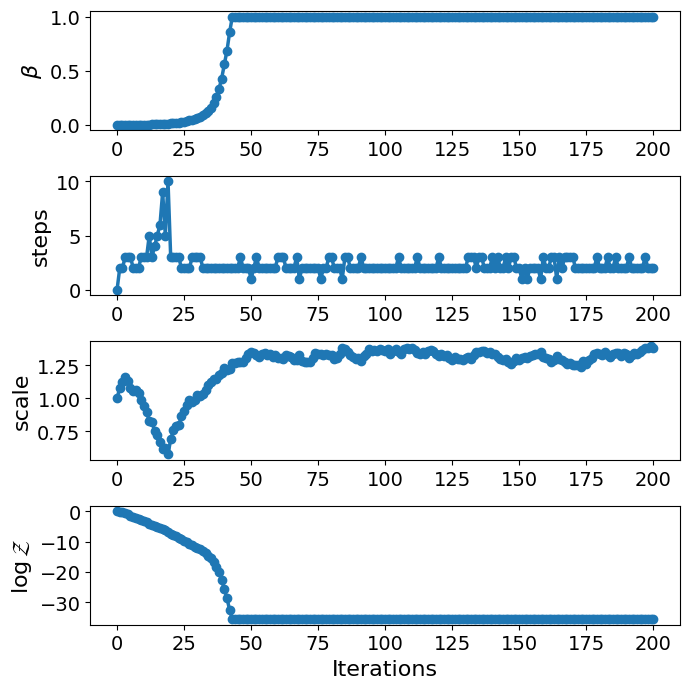

In [30]:
_ = pc.plotting.run(all_res[42], width=7, height=7)
_ = pc.plotting.run(all_res[16384], width=7, height=7)

#_ = pc.plotting.trace(results, labels=labels)

## Vary n_particles and gamma

In [31]:
nparticles = 1000
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus)

In [32]:
res_NP = {}
for seed in [42, 16384]:
    n = noise[seed]
    lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+n[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]
    results = sampler.run_sampler(lst_bins, add_samples=0) #XXX
    res_NP[seed] = results
    print(f"SEED: {seed}")
    print_res(results)

Iter: 12it [00:37,  3.96s/it, beta=0.00181, calls=31000, ESS=0.949, logZ=-4, accept=0.264, N=2, scale=0.941, corr=0.744]   /home/christian/Documents/research/MIST/mistsim/.venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
Iter: 46it [03:34,  4.66s/it, beta=1, calls=101000, ESS=0.994, logZ=-33.2, accept=0.271, N=2, scale=1.17, corr=0.661]     

SEED: 42
Mean values =  [-0.1999744 19.923904  79.98667  ]
Standard deviation values =  [0.00723254 0.43206695 0.09652647]

[0.01280025 0.38193107 0.01666347]
[0.00353918 0.17611988 0.13808183]



Iter: 46it [03:12,  4.19s/it, beta=1, calls=99000, ESS=0.969, logZ=-35.5, accept=0.255, N=2, scale=1.15, corr=0.685]        

SEED: 16384
Mean values =  [-0.21317576 20.668339   79.88007   ]
Standard deviation values =  [0.00827152 0.4625347  0.0999743 ]

[6.18070216 3.23363567 0.15013313]
[1.59290569 1.44494841 1.19957285]


In [33]:
res_gamma = {}
for seed in [42, 16384]:
    n = noise[seed]
    lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+n[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]
    results = sampler.run_sampler(lst_bins, add_samples=0, gamma=0.50) #XXX
    res_gamma[seed] = results
    print(f"SEED: {seed}")
    print_res(results)

Iter: 46it [03:12,  4.19s/it, beta=1, calls=220000, ESS=0.967, logZ=-33.4, accept=0.23, N=4, scale=1.13, corr=0.492]       

SEED: 42
Mean values =  [-0.19942763 19.88583    79.9898    ]
Standard deviation values =  [0.00699948 0.42291227 0.09969256]

[0.28700412 0.57412778 0.01275225]
[0.08177257 0.2699616  0.10231958]



Iter: 45it [03:12,  4.27s/it, beta=1, calls=216000, ESS=0.953, logZ=-35.2, accept=0.237, N=4, scale=1.13, corr=0.498]      

SEED: 16384
Mean values =  [-0.21279672 20.650408   79.878296  ]
Standard deviation values =  [0.00851271 0.46618643 0.10009053]

[6.013588   3.14961234 0.15236192]
[1.50324855 1.39516671 1.21594027]
